# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import os
import hashlib
import random
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import time
import copy
from tqdm import tqdm

# Data Preprocessing and Visualization: Places365

Places365 is located in /datasets-2/places365/places365_standard/ 

In this directory, there are a number of subdirectories for each class. Within each subdirectory are jpgs of the actual images comprising the dataset. 

In order to use this large dataset on DSMLP and get around the disk quota of 10GB per user, we have to create a custom dataloader and dataset. This is because of our requirements of the dataset: divide the train data into training, validation, and testing datasets, and apply masking to the individual images so that they can be fed into the context encoder.

In [2]:
class Places365Dataset(Dataset):
    def __init__(self, root, file_list, transform=None):
        self.root = root
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.file_list[idx])
        image = Image.open(img_name).convert('RGB')
        label = img_name.split('/')[5]

        original = image

        if self.transform:
            original = self.transform(original)
        
        masked, true_center = self.mask_center_region(original)
        
        return masked, true_center, original, label
    
    def mask_center_region(self, image):
        masked_image = image[:].clone()
        masked_image[0, 32+4:96-4, 32+4:96-4] = 2*117.0/255.0 - 1.0
        masked_image[1, 32+4:96-4, 32+4:96-4] = 2*104.0/255.0 - 1.0
        masked_image[2, 32+4:96-4, 32+4:96-4] = 2*123.0/255.0 - 1.0
        true_center = image[:, 32:96, 32:96]
        
        return masked_image, true_center

In [3]:
dataset_root = '/datasets-2/places365/places365_standard'
train_txt_file = os.path.join(dataset_root, 'train.txt')

# Open the text file in read mode
with open(train_txt_file, 'r') as file:
    num_lines = sum(1 for line in file)

print("Number of image names in the train.txt:", num_lines)

# Read the content of train.txt and val.txt files
def read_file(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()
    return [line.strip() for line in lines]

train_files = read_file(train_txt_file)

# Shuffle the filenames to randomize the order
random.shuffle(train_files)

# Split the dataset into training and testing subsets
train_split_ratio = 0.7
val_split_ratio = 0.2
test_split_ratio = 0.1
num_train_samples = int(len(train_files) * train_split_ratio)
num_val_samples = int(len(train_files) * val_split_ratio)
num_test_samples = int(len(train_files) * test_split_ratio)
train_subset = train_files[:num_train_samples]
val_subset = train_files[num_train_samples:(num_train_samples+num_val_samples)]
test_subset = train_files[(num_train_samples+num_val_samples):]

# Define transformations for data preprocessing
train_transform = T.Compose([
    T.ToTensor(),
    T.Resize((128,128), antialias=True),
])

# Create train, val, test datasets
batch_size= 64

train_dataset = Places365Dataset(dataset_root, train_subset, transform=train_transform)
val_dataset = Places365Dataset(dataset_root, val_subset, transform=train_transform)
test_dataset = Places365Dataset(dataset_root, test_subset, transform=train_transform)

places365_train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
places365_val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2)
places365_test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2)

print("Number of images in the places365_train_loader:", len(places365_train_loader) * batch_size)
print("Number of images in the places365_val_loader:", len(places365_val_loader) * batch_size)

Number of image names in the train.txt: 1803460
Number of images in the places365_train_loader: 1262464
Number of images in the places365_val_loader: 360704


torch.Size([64, 3, 128, 128]) torch.Size([64, 3, 64, 64]) torch.Size([64, 3, 128, 128])
Masked Image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


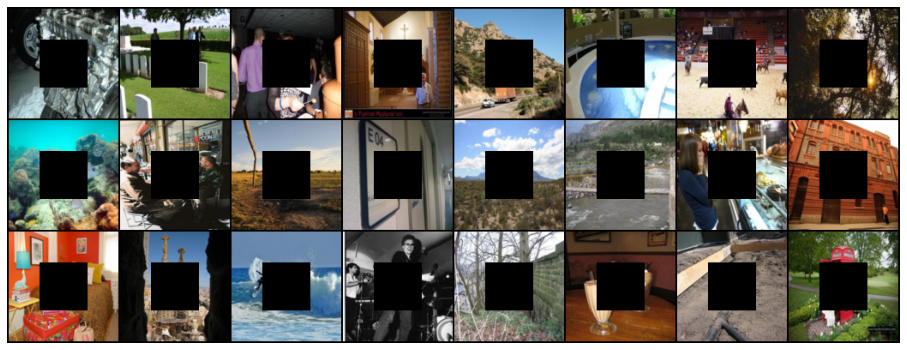

True Center


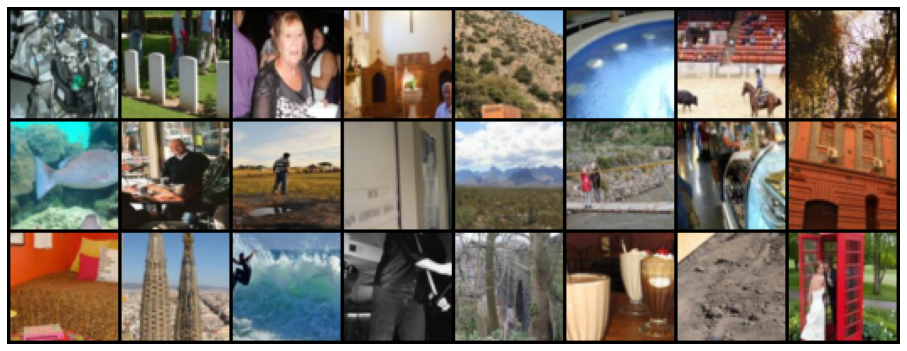

Original Image


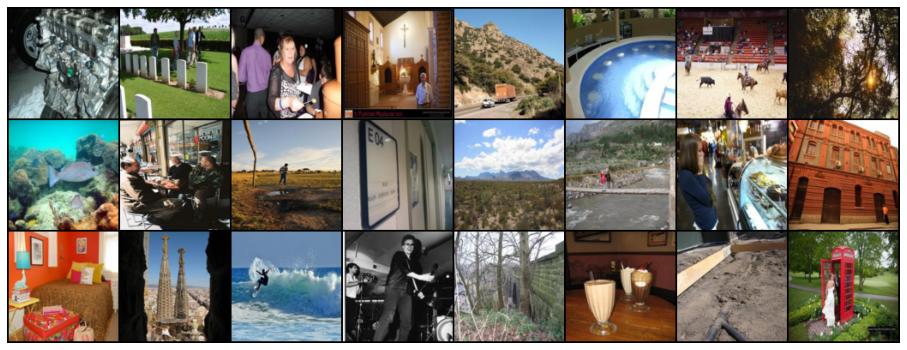

Image Name ('engine_room', 'cemetery', 'beer_hall', 'church-indoor', 'mountain_path', 'swimming_pool-indoor', 'arena-rodeo', 'forest-broadleaf', 'underwater-ocean_deep', 'coffee_shop', 'watering_hole', 'corridor', 'desert-vegetation', 'rope_bridge', 'bakery-shop', 'synagogue-outdoor', 'childs_room', 'church-outdoor', 'wave', 'stage-indoor', 'viaduct', 'ice_cream_parlor', 'excavation', 'phone_booth', 'soccer_field', 'doorway-outdoor', 'shopfront', 'canyon', 'boardwalk', 'bakery-shop', 'home_office', 'desert-vegetation', 'lagoon', 'banquet_hall', 'bowling_alley', 'gift_shop', 'gazebo-exterior', 'beer_hall', 'parking_garage-indoor', 'clothing_store', 'nursery', 'gymnasium-indoor', 'harbor', 'desert-sand', 'park', 'valley', 'gymnasium-indoor', 'yard', 'inn-outdoor', 'ocean', 'corral', 'synagogue-outdoor', 'locker_room', 'swimming_hole', 'field_road', 'food_court', 'tree_farm', 'operating_room', 'childs_room', 'bedroom', 'synagogue-outdoor', 'industrial_area', 'temple-asia', 'pond')


In [4]:
masked, true_center, original, image_name = next(iter(places365_train_loader))
print(masked.shape, true_center.shape, original.shape)

def display_samples(image):
    npimg = image.numpy()
    plt.figure(figsize = (16, 16))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

print('Masked Image')
display_samples(torchvision.utils.make_grid(masked[:24]))
print('True Center')
display_samples(torchvision.utils.make_grid(true_center[:24]))
print('Original Image')
display_samples(torchvision.utils.make_grid(original[:24]))
print('Image Name', image_name)

# Context Encoder Architecture

This is the Context Encoder as outlined in Context Encoders: Feature Learning by Inpainting by Deepak Pathak (https://arxiv.org/abs/1604.07379).

The encoder takes in a 128x128 image with a 64x64 masked region and compresses its features through a series of convolutional blocks. The decoder then upsamples the feature representation into a a 64x64 image which is the model's best guess for a fill to the masked region.

In [5]:
class ContextEncoder(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(ContextEncoder, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv_bottleneck = nn.Sequential(
            nn.Conv2d(512, bottleneck_channels, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(bottleneck_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv_bottleneck(x)
        return x

In [6]:
class ContextDecoder(nn.Module):
    def __init__(self, bottleneck_channels=2048, out_channels=3):
        super(ContextDecoder, self).__init__()
        
        self.transpose_conv1 = nn.Sequential(
            nn.ConvTranspose2d(bottleneck_channels, 512, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv3 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv4 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        
        self.transpose_conv5 = nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, bias=False)
        
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.transpose_conv1(x)
        x = self.transpose_conv2(x)
        x = self.transpose_conv3(x)
        x = self.transpose_conv4(x)
        x = self.transpose_conv5(x)
        x = self.tanh(x)
        return x

In [7]:
class Generator(nn.Module):
    def __init__(self, in_channels=3, bottleneck_channels=2048):
        super(Generator, self).__init__()
        
        self.context_encoder = ContextEncoder(in_channels=in_channels, bottleneck_channels=bottleneck_channels)
        
        self.context_decoder = ContextDecoder(bottleneck_channels=bottleneck_channels, out_channels=in_channels)
        
    def forward(self, x):
        encoder_output = self.context_encoder(x)
        decoder_output = self.context_decoder(encoder_output)
        return decoder_output
        

In [8]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.fc5 = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.fc5(x)
        x = self.sigmoid(x)
        return x

# Training

We train our context encoder using a GAN framework. The generator will be trained using a linear combination of reconstruction loss and adversarial loss with the ADAM optimization method. Our hyperparameters include: number of epochs, generator learning rate, discriminator learning rate, optimization betas, and loss function weights. These hyperparameters have been tuned through multiple sessions of training. Periodically, the model weights are saved to the /weights directory in order to save progress and allow the model to be loaded in from disk even after the kernel has been refreshed/restarted. 

In [9]:
def store_weights(generator, discriminator, root = "./weights/"):
    if not os.path.exists(root):
        os.makedirs(root)
    torch.save(generator.state_dict(), root + "generator")
    torch.save(discriminator.state_dict(), root + "discriminator")

def load_models(root = "./weights/"):
    generator = Generator(in_channels=3, bottleneck_channels=2048)
    discriminator = Discriminator(in_channels=3)
    
    if os.path.exists(root):
        generator.load_state_dict(torch.load(root + "generator"))
        discriminator.load_state_dict(torch.load(root + "discriminator"))
    
    return generator, discriminator

In [10]:
def print_metrics(batch_idx, total_loss, num_samples, start_time, discriminator_real_output, discriminator_fake_output):
    correct_real = (discriminator_real_output > 0.5).sum().item()
    correct_fake = (discriminator_fake_output <= 0.5).sum().item()
    total_real = discriminator_real_output.size(0)
    total_fake = discriminator_fake_output.size(0)
    accuracy_real = correct_real / total_real
    accuracy_fake = correct_fake / total_fake
    execution_time = time.time() - start_time
    print('Batch %d | Epoch Loss: %.4f | D(Real) Acc.: %.4f | D(Fake) Acc.: %.4f | Execution Time: %.4f' 
          % (batch_idx + 1, total_loss / num_samples, accuracy_real, accuracy_fake, execution_time))

In [11]:
def print_epoch_summary(epoch, total_loss, num_samples, start_time):
    execution_time = time.time() - start_time
    print('Epoch %d | Context-Encoder Loss: %.4f | Execution Time: %.4f' % (epoch + 1, total_loss / num_samples, execution_time))

In [12]:
def train(generator, discriminator, epochs, batch_size, learning_rate_G, learning_rate_D, betas, train_loader):  
    
    generator.to(device)
    discriminator.to(device)
    
    # Different learning rates for generator and discriminator
    optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate_G, betas=betas)
    optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate_D, betas=betas)
    
    # Learning rate schedulers
    scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, step_size=30, gamma=0.1)
    scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, step_size=30, gamma=0.1)
    
    loss_func_BCE = nn.BCELoss()
    loss_func_BCE.to(device)
    
    # Set weights for our total loss
    weight_reconstruction = 0.999
    weight_adversarial = 0.001
    
    for epoch in range(epochs):
        
        total_loss = 0.0
        num_samples = 0
        start_time = time.time()
        
        for batch_idx, (masked, true_center, original, label) in tqdm(enumerate(train_loader), total=len(train_loader)):
            masked, true_center, original = masked.to(device), true_center.to(device), original.to(device)
            curr_batch_size = masked.size(0)
            real_labels = torch.ones((curr_batch_size, 1, 1, 1)).to(device)
            fake_labels = torch.zeros((curr_batch_size, 1, 1, 1)).to(device)
            
            # Train Discriminator with real
            optimizer_D.zero_grad()
            discriminator_real_output = discriminator(true_center)
            discriminator_real_loss = loss_func_BCE(discriminator_real_output, real_labels)
            
            # Train Discriminator with fake
            generator_output = generator(masked)
            discriminator_fake_output = discriminator(generator_output.detach())
            discriminator_fake_loss = loss_func_BCE(discriminator_fake_output, fake_labels)
            discriminator_total_loss = discriminator_real_loss + discriminator_fake_loss
            discriminator_total_loss.backward()
            optimizer_D.step()
            
            # Train Generator
            optimizer_G.zero_grad()
            discriminator_fake_output_for_gen = discriminator(generator_output)
            adversarial_loss = loss_func_BCE(discriminator_fake_output_for_gen, real_labels)
            
            l2_weights = torch.empty(generator_output.size()).fill_(weight_reconstruction * 10)
            l2_weights[:,:, 4:64-4, 4:64-4] = weight_reconstruction
            l2_weights = l2_weights.to(device)
            
            reconstruction_loss = torch.mean(l2_weights * (generator_output - true_center).pow(2))
            generator_total_loss = weight_reconstruction * reconstruction_loss + weight_adversarial * adversarial_loss
            generator_total_loss.backward()
            optimizer_G.step()
            
            # Metrics / Save weights every 2000 batches
            total_loss += generator_total_loss.item() * curr_batch_size
            num_samples += curr_batch_size
            
            if batch_idx % 1999 == 0:
                store_weights(generator, discriminator, root = "./weights/")
                print_metrics(batch_idx, total_loss, num_samples, start_time, discriminator_real_output, discriminator_fake_output)

        # Step the learning rate schedulers
        scheduler_G.step()
        scheduler_D.step()
        
        print_epoch_summary(epoch, total_loss, num_samples, start_time)

In [16]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Using device ", device)

Using device  cuda


In [ ]:
learning_rate_G = 0.0008  # Generator learning rate
learning_rate_D = 0.0001  # Discriminator learning rate
epochs = 3
betas = (0.5, 0.999)

generator, discriminator = load_models()
train(generator=generator, discriminator=discriminator, epochs=epochs, batch_size=64, learning_rate_G=learning_rate_G, learning_rate_D=learning_rate_D, betas=betas, train_loader=places365_train_loader)

Using device  cuda


  0%|          | 1/19726 [00:01<6:12:58,  1.13s/it]

Batch 1 | Epoch Loss: 0.0581 | D(Real) Acc.: 0.9844 | D(Fake) Acc.: 0.9531 | Execution Time: 1.1612


 10%|█         | 2000/19726 [15:04<2:43:48,  1.80it/s]

Batch 2000 | Epoch Loss: 0.0569 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 904.3266


 20%|██        | 3999/19726 [30:17<2:36:43,  1.67it/s]

Batch 3999 | Epoch Loss: 0.0568 | D(Real) Acc.: 0.3438 | D(Fake) Acc.: 1.0000 | Execution Time: 1817.3357


 30%|███       | 5998/19726 [45:39<2:10:52,  1.75it/s]

Batch 5998 | Epoch Loss: 0.0566 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.8438 | Execution Time: 2739.3472


 41%|████      | 7997/19726 [1:00:34<1:53:19,  1.72it/s]

Batch 7997 | Epoch Loss: 0.0564 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 3634.9704


 51%|█████     | 9996/19726 [1:15:03<1:37:42,  1.66it/s]

Batch 9996 | Epoch Loss: 0.0562 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.7188 | Execution Time: 4503.9880


 61%|██████    | 11995/19726 [1:29:38<1:09:42,  1.85it/s]

Batch 11995 | Epoch Loss: 0.0560 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9688 | Execution Time: 5378.7719


 71%|███████   | 13994/19726 [1:44:16<54:48,  1.74it/s]  

Batch 13994 | Epoch Loss: 0.0559 | D(Real) Acc.: 0.7969 | D(Fake) Acc.: 1.0000 | Execution Time: 6256.0823


 81%|████████  | 15993/19726 [1:58:52<34:42,  1.79it/s]

Batch 15993 | Epoch Loss: 0.0557 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 7132.1843


 91%|█████████ | 17992/19726 [2:13:49<17:44,  1.63it/s]

Batch 17992 | Epoch Loss: 0.0555 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9688 | Execution Time: 8029.0401


100%|██████████| 19726/19726 [2:27:14<00:00,  2.23it/s]

Epoch 1 | Context-Encoder Loss: 0.0554 | Execution Time: 8834.1907



  0%|          | 1/19726 [00:00<5:02:45,  1.09it/s]

Batch 1 | Epoch Loss: 0.0472 | D(Real) Acc.: 0.7344 | D(Fake) Acc.: 1.0000 | Execution Time: 0.9539


 10%|█         | 2000/19726 [14:45<2:49:48,  1.74it/s]

Batch 2000 | Epoch Loss: 0.0539 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 885.4165


 20%|██        | 3999/19726 [30:03<2:40:14,  1.64it/s]

Batch 3999 | Epoch Loss: 0.0538 | D(Real) Acc.: 0.8750 | D(Fake) Acc.: 1.0000 | Execution Time: 1804.0062


 30%|███       | 5998/19726 [45:23<2:22:12,  1.61it/s]

Batch 5998 | Epoch Loss: 0.0538 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9844 | Execution Time: 2724.0054


 41%|████      | 7997/19726 [1:00:51<2:01:40,  1.61it/s]

Batch 7997 | Epoch Loss: 0.0538 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 3651.9133


 51%|█████     | 9996/19726 [1:16:33<1:37:21,  1.67it/s]

Batch 9996 | Epoch Loss: 0.0537 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.5312 | Execution Time: 4593.1492


 61%|██████    | 11995/19726 [1:32:03<1:16:07,  1.69it/s]

Batch 11995 | Epoch Loss: 0.0536 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9688 | Execution Time: 5523.6991


 71%|███████   | 13994/19726 [1:47:18<56:57,  1.68it/s]  

Batch 13994 | Epoch Loss: 0.0536 | D(Real) Acc.: 0.6719 | D(Fake) Acc.: 1.0000 | Execution Time: 6438.4625


 81%|████████  | 15993/19726 [2:02:24<37:31,  1.66it/s]

Batch 15993 | Epoch Loss: 0.0535 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 7344.7772


 91%|█████████ | 17992/19726 [2:17:38<17:20,  1.67it/s]

Batch 17992 | Epoch Loss: 0.0535 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9688 | Execution Time: 8258.1403


100%|██████████| 19726/19726 [2:31:00<00:00,  2.18it/s]

Epoch 2 | Context-Encoder Loss: 0.0535 | Execution Time: 9060.4914



  0%|          | 1/19726 [00:00<5:01:37,  1.09it/s]

Batch 1 | Epoch Loss: 0.0492 | D(Real) Acc.: 0.7188 | D(Fake) Acc.: 1.0000 | Execution Time: 0.9523


 10%|█         | 2000/19726 [15:49<3:03:42,  1.61it/s]

Batch 2000 | Epoch Loss: 0.0532 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9844 | Execution Time: 949.1160


 20%|██        | 3999/19726 [31:37<2:40:55,  1.63it/s]

Batch 3999 | Epoch Loss: 0.0531 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 1.0000 | Execution Time: 1897.2784


 30%|███       | 5998/19726 [47:26<2:29:28,  1.53it/s]

Batch 5998 | Epoch Loss: 0.0531 | D(Real) Acc.: 1.0000 | D(Fake) Acc.: 0.9531 | Execution Time: 2846.2041


 37%|███▋      | 7253/19726 [57:22<1:35:21,  2.18it/s]

# Evaluation

We will be qualitatively evaluating our model as the model's accuracy is difficult to quantitatively analyze. After loading in our model and its weights, we will display the original input image versus the model's output. Since the input to the model is a masked image and the model's output is a best guess at a fill for the mask, we have chosen to display the original image (without masking) versus the masked image with the model's output inpainted in order to better visualize how well the model was able to understand the context of the image.

In [17]:
eval_generator, eval_discriminator = load_models()
eval_generator.eval()

Generator(
  (context_encoder): ContextEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv4): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (conv5)

In [18]:
def display_generator_samples(image):
    npimg = image.cpu().numpy()
    plt.figure(figsize=(16, 16))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Original Image (Train)


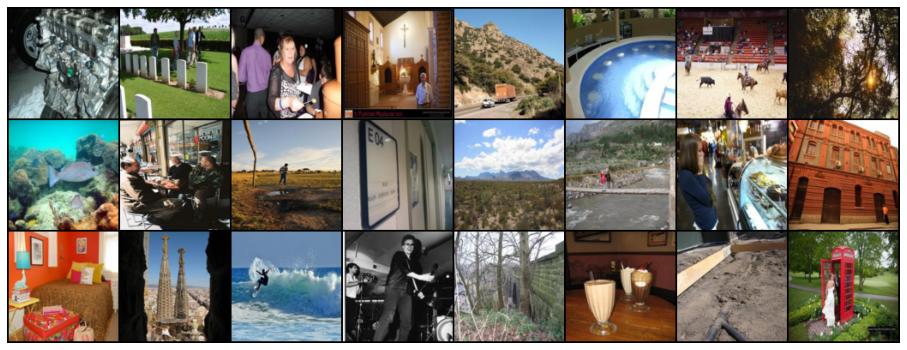

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model Output (Train)


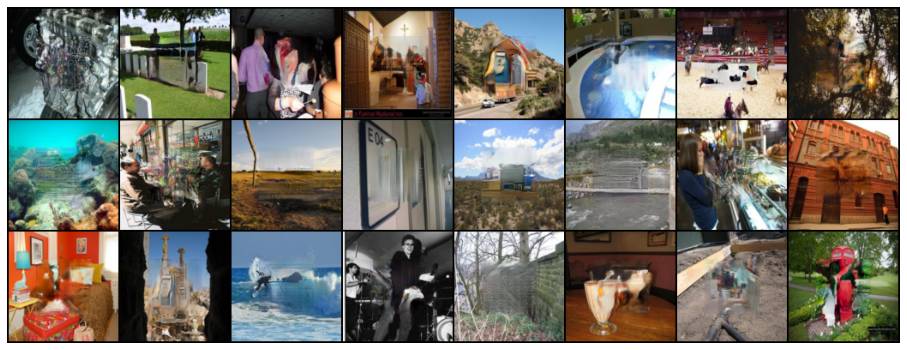

In [20]:
#Evaluate train loader
masked, true_center, original, label = next(iter(places365_train_loader))

model_output = eval_generator(masked)

inpainted_samples = masked.clone()
inpainted_samples[:,:, 32:96, 32:96] = model_output

original_selected = original[:24]
inpainted_selected = inpainted_samples[:24]

print('Original Image (Train)')
display_generator_samples(torchvision.utils.make_grid(original_selected))
print('Model Output (Train)')
display_generator_samples(torchvision.utils.make_grid(inpainted_selected))

Original Image (Validation)


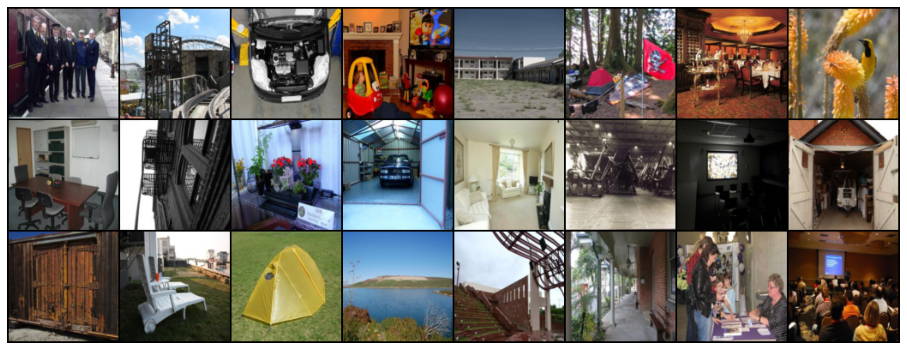

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Model Output (Validation)


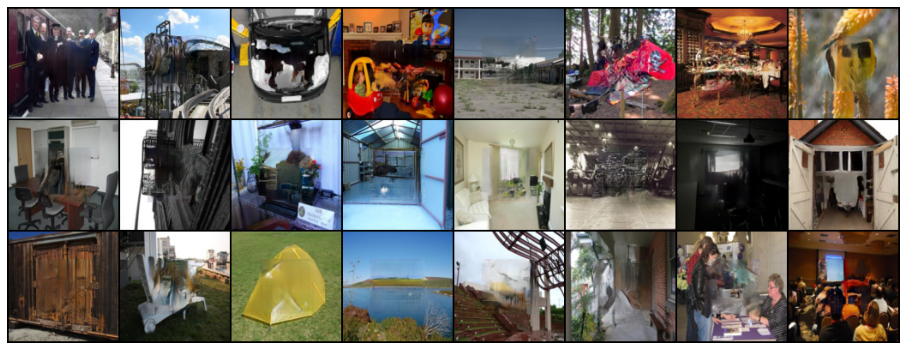

In [21]:
#Evaluate val loader
vmasked, vtrue_center, voriginal, vlabel = next(iter(places365_val_loader))

vmodel_output = eval_generator(vmasked)

vinpainted_samples = vmasked.clone()
vinpainted_samples[:,:, 32:96, 32:96] = vmodel_output

voriginal_selected = voriginal[:24]
vinpainted_selected = vinpainted_samples[:24]

print('Original Image (Validation)')
display_generator_samples(torchvision.utils.make_grid(voriginal_selected))
print('Model Output (Validation)')
display_generator_samples(torchvision.utils.make_grid(vinpainted_selected))